# PgRouting

PgRouting é uma extensão do PostGIS para cálculos de roteamento. Este notebook apresenta um exemplo mínimo com preparação da base e obtenção de rota com impedância baseada na distância.

## Rede viária

Estou usando um recorte do sistema viário da cidade de João Pessoa e arredores da base do OpenStreetMap. A importação para um banco de dados PostgreSQL com extensão PostGIS e PgRouting pode se valer do utilitário osm2pgsql. Por exemplo:

```
osm2pgsql joaopessoa-osm.pbf -c -d postgres -U postgres -W -H localhost
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import psycopg2
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Conexão com o banco de dados

In [2]:
conn = psycopg2.connect(host='localhost', database='postgres', user='postgres', password='postgres')

## Consultando a rede a partir da tabela de linhas filtrada

Não precisamos de todas as linhas do OSM para usar nos cálculos de roteamento. Queremos apenas as vias públicas dirigíveis.

In [3]:
highway_include = ('trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 
                   'secondary_link', 'tertiary', 'tertiary_link', 'residential')
gdf = gpd.read_postgis(f'SELECT * FROM planet_osm_line WHERE highway IN {highway_include}', con=conn, geom_col='way')

<AxesSubplot:>

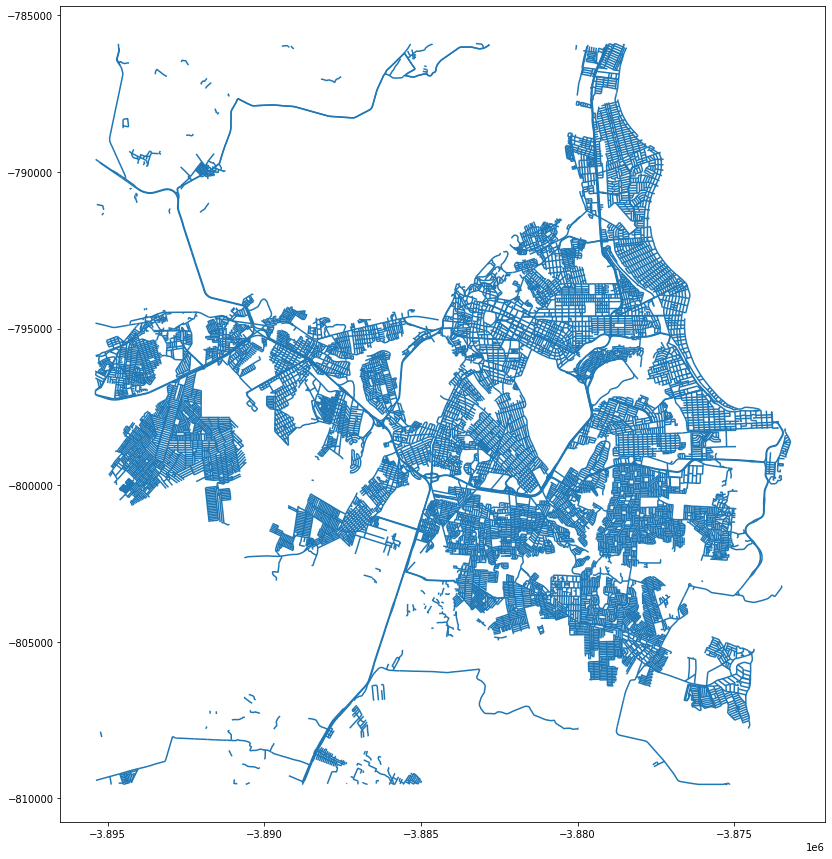

In [4]:
gdf.plot(figsize=(15, 15))

É possível usar diferentes filtros para se chegar à rede que se precisa. Estou seguindo com essa como exercício.

## Criação da tabela

Vamos criar uma tabela já com o filtro.
```
CREATE TABLE osm_network AS
  SELECT osm_id, highway, oneway, surface, name, way geom FROM planet_osm_line 
  WHERE highway IN ('trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 
                    'secondary_link', 'tertiary', 'tertiary_link', 'residential');
```

## Ajustes topológicos necessários

Garantindo que todas as arestas estão em segmentos separados e calculando a extensão de cada um.

```
SELECT pgr_nodeNetwork('osm_network', 1, 'osm_id', 'geom');

ALTER TABLE osm_network_noded
  ADD COLUMN name VARCHAR,
  ADD COLUMN highway VARCHAR,
  ADD COLUMN oneway VARCHAR,
  ADD COLUMN surface VARCHAR,
  ADD COLUMN length DOUBLE PRECISION;

UPDATE osm_network_noded AS new
SET
  name = old.name,
  highway = old.highway,
  oneway = old.oneway,
  surface = old.surface,
  length = ST_Length(new.geom)
FROM osm_network AS old
WHERE new.old_id = old.osm_id;
```

Obtendo os nós.

```
SELECT pgr_createTopology('osm_network_noded', 1, 'geom', 'id');
```

Dando uma olhada na tabela de nós.

In [5]:
nodes = gpd.read_postgis('SELECT * FROM osm_network_noded_vertices_pgr', con=conn, geom_col='the_geom')

<AxesSubplot:>

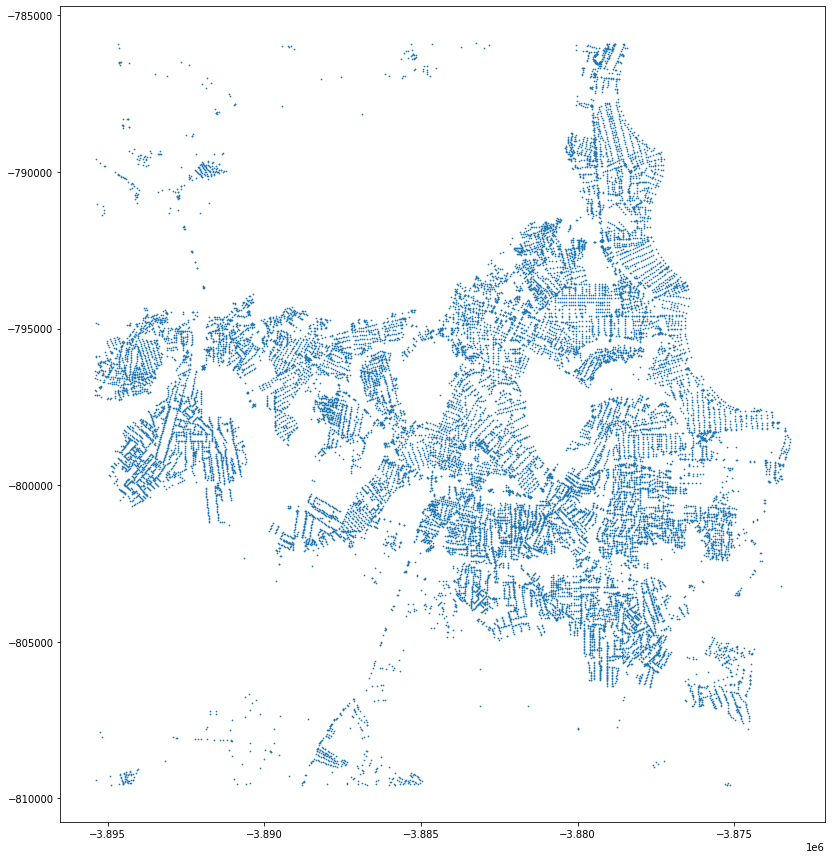

In [6]:
nodes.plot(figsize=(15, 15), markersize=0.5)

Vendo um pouco mais de perto a região dos bairros Ernesto Geisel e Cuiá.

<AxesSubplot:>

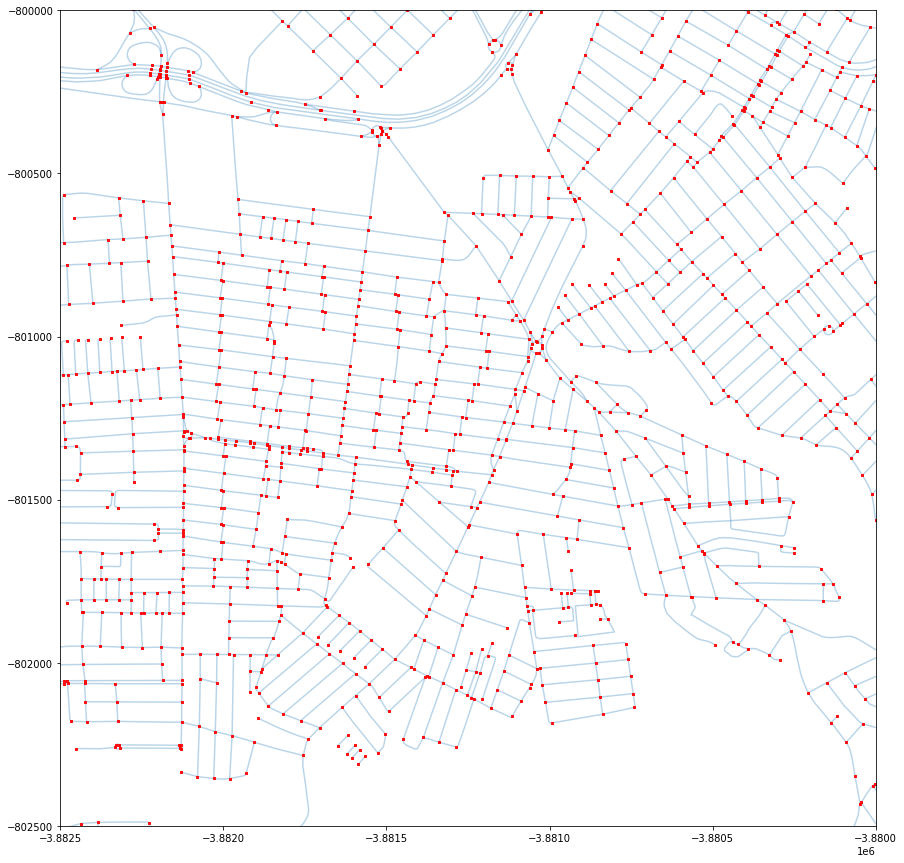

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_xlim([-3882500, -3880000])
ax.set_ylim([-802500, -800000])
gdf.plot(ax=ax, alpha=0.3, zorder=1)
nodes.plot(ax=ax, alpha=0.9, color='red', markersize=3, marker='s', zorder=2)

Temos o que o Pg Routing precisa para o roteamento.

## Exemplo de caminho mais curto entre dois nós

Entre os nós 2500 e 3000.

In [8]:
def get_route_from_nodes(start, end):
    query = """
        WITH
          route AS (
            SELECT *
              FROM pgr_dijkstra(
                'SELECT id, source, target,
                  length AS cost,
                  CASE oneway WHEN ''yes'' THEN -1 ELSE length END AS reverse_cost
                FROM osm_network_noded',
              %(start)s, %(end)s)
           )
        SELECT r.*, e.geom, e.name FROM 
          osm_network_noded e,
          route r
        WHERE r.edge = e.id
        ORDER BY r.seq
    """
    return gpd.read_postgis(query, con=conn, geom_col='geom', params={'start': start, 'end': end})

route = get_route_from_nodes(2500, 3000)

In [9]:
streets = gpd.read_postgis('SELECT * FROM osm_network_noded', con=conn, geom_col='geom')

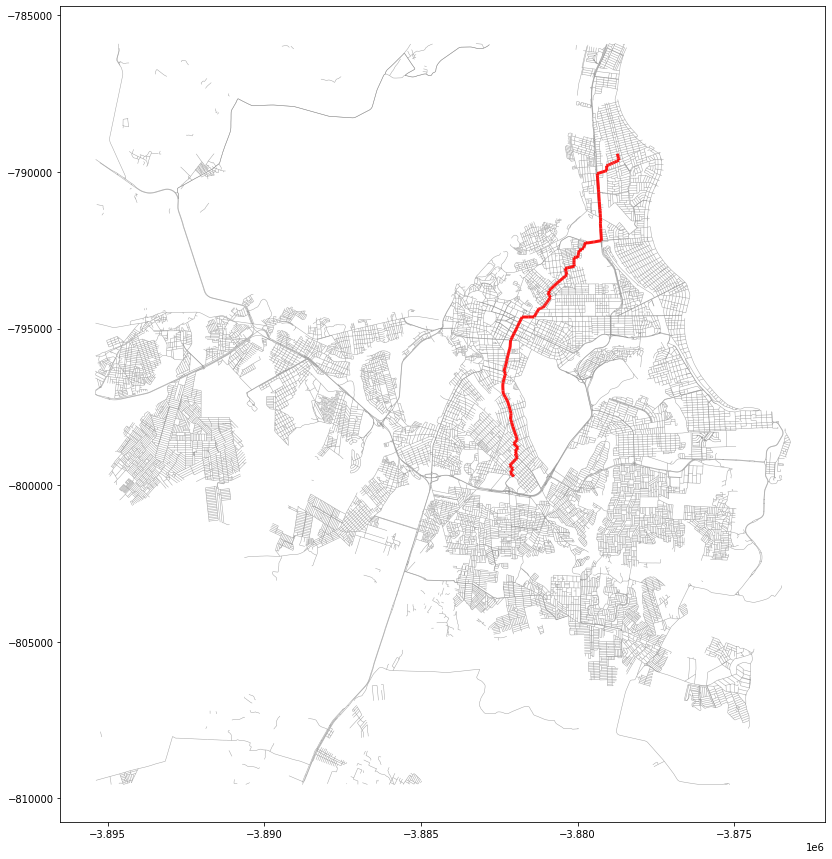

In [10]:
def plot_route(route_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    streets.plot(ax=ax, edgecolor='gray', alpha=0.7, zorder=1, linewidth=0.5)
    route_gdf.plot(ax=ax, alpha=0.9, edgecolor='red', linewidth=3, zorder=2)

plot_route(route)

In [11]:
m = folium.Map(location=[-7.135231, -34.855469], zoom_start=13, tiles='CartoDB dark_matter', control_scale=True)
route_geojson = route.to_crs(epsg='4326').to_json()
folium.GeoJson(route_geojson).add_to(m)

In [12]:
m

## Exemplo de caminho mais curto entre dois pontos

Passando pares de coordenadas e obtendo o nó mais próximo de cada um.

In [13]:
def get_closest_node(lat, lon):
    query = """
       SELECT id FROM osm_network_noded_vertices_pgr 
         ORDER BY the_geom <-> ST_Transform(ST_GeometryFromText('POINT(%(lon)s %(lat)s)', 4326), 3857)
         LIMIT 1
    """
    result = pd.read_sql(query, params={'lon': lon, 'lat': lat}, con=conn)
    return int(result.id.values[0])

In [14]:
get_closest_node(-7.143405, -34.890937)

14700

Calculando rota dirigível com menor distância entre o Hospital de Valentina e o Hospital de Trauma Senador Humberto Lucena.

In [26]:
hospital_valentina = get_closest_node(-7.199149, -34.851329)
hospital_de_trauma = get_closest_node(-7.116432, -34.842307)

route_to_hospital = get_route_from_nodes(hospital_valentina, hospital_de_trauma)

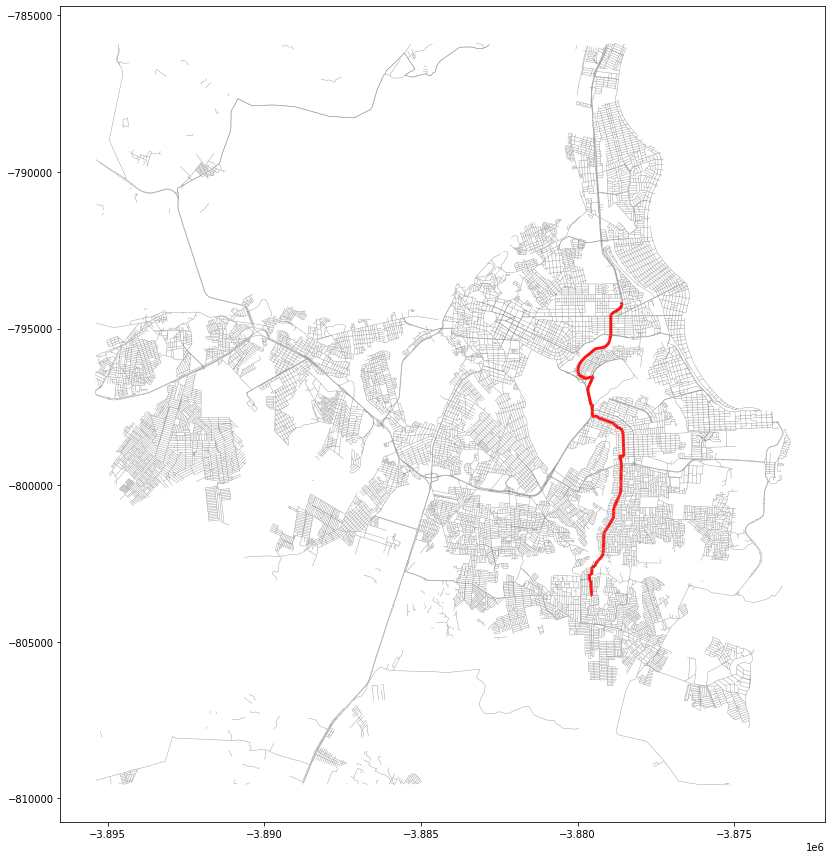

In [27]:
plot_route(route_to_hospital)

In [23]:
m = folium.Map(location=[-7.135231, -34.855469], zoom_start=14, tiles='CartoDB dark_matter', control_scale=True)
route_geojson = route_to_hospital.to_crs(epsg='4326').to_json()
folium.GeoJson(route_geojson).add_to(m)

In [24]:
m

É apenas um exercício. Há muito a se ajustar na base - por exemplo, remover falsos nós, como aqueles em viadutos - e o valor de custo pode ser aprimorado com outras variáveis, como tempo, calculado com base na hierarquia da via, informação de velocidade máxima, histórico de volume de tráfego etc.

Há outros algoritmos do Pg Routing para experimentar.

Pode-se otimizar o roteamento também entre nós que não existem na tabela de nós, para um cálculo mais preciso.